In [1]:
#######################################
########## IMPORTS ####################
from localLibrary_AWSConnector import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime 


from sklearn.model_selection import KFold # import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier



In [58]:
#HELPER FUNCTIONS

#Returns dictionary of dataframes
def get_data():
    data_list = []
    data_dict = {}
    
    file_dir = os.getcwd() + '\\data\\'
    items = os.listdir(file_dir)
    
    for i in items:
        file = i.replace('.csv', '')
        data_list.append(file)

        # Save STM files as DataFrames
        data_dict[file] = pd.read_csv(file_dir + i, index_col=0)

    print(data_list)
    
    return data_dict

#Convert time helper
def _convert_time_to_int(time):
    #print(time)
    if time != time:
        return 0
    elif time == 0:
        return 0
    else:
        return int(''.join(c for c in time[:10] if c.isdigit()))

#convert date columns to int  for given df   
def convert_time_int(df):
    
    df['EarliestCRM_int'] = [_convert_time_to_int(x) for x in df['EarliestCRM']]
    df['LatestCRM_int'] = [_convert_time_to_int(x) for x in df['LatestCRM']]

    df['LatestSeatGeek_int'] = [_convert_time_to_int(x) for x in df['LatestSeatGeekDate']]
    df['EarliestSeatGeek_int'] = [_convert_time_to_int(x) for x in df['EarliestSeatGeekDate']]

    df['EarliestMarketo_int'] = [_convert_time_to_int(x) for x in df['EarliestMarketoDate']]
    df['LatestMarketo_int'] = [_convert_time_to_int(x) for x in df['LatestMarketoDate']]

    df['EarliestFanatics_int'] = [_convert_time_to_int(x) for x in df['EarliestFanaticsDate']]
    df['LatestFanatics_int'] = [_convert_time_to_int(x) for x in df['LatestFanaticsDate']]

    df['EarliestYinzcam_int'] = [_convert_time_to_int(x) for x in df['EarliestYinzcamDate']]
    df['LatestYinzcam_int'] = [_convert_time_to_int(x) for x in df['LatestYinzcamDate']]
    
    df['Purchase_date'] = [_convert_time_to_int(x) for x in df['Purchase_date']]
    
    return df

#Creates date difference column (latest - earliest)
def calculate_time_diff(df):
    
    df['CRM_diff'] = df['LatestCRM_int'] - df['EarliestCRM_int']
    df['SeatGeek_diff'] = df['LatestSeatGeek_int'] - df['EarliestSeatGeek_int']
    df['Marketo_diff'] = df['LatestMarketo_int'] - df['EarliestMarketo_int']
    df['Fanatics_diff'] = df['LatestFanatics_int'] - df['EarliestFanatics_int']
    df['Yinzcam_diff'] = df['LatestYinzcam_int'] - df['EarliestYinzcam_int']
    
    
    df['SeatGeek_to_purchase'] = [p-s if s > 0 else p for s,p in zip(df['LatestSeatGeek_int'], df['Purchase_date'])]
    df['CRM_to_purchase'] = [p-s if s > 0 else p for s,p in zip(df['LatestCRM_int'], df['Purchase_date'])]
    df['Marketo_to_purchase'] = [p-s if s > 0 else p for s,p in zip(df['LatestMarketo_int'], df['Purchase_date'])]
    df['Fanatics_to_purchase'] = [p-s if s > 0 else p for s,p in zip(df['LatestFanatics_int'], df['Purchase_date'])]
    df['Yinzcam_to_purchase'] = [p-s if s > 0 else p for s,p in zip(df['LatestYinzcam_int'], df['Purchase_date'])]

#     df['SeatGeek_to_purchase'] = [p-s if p > 0 else 0 for s,p in zip(df['LatestSeatGeek_int'], df['Purchase_date'])]
#     df['CRM_to_purchase'] = [p-s if p > 0 else 0 for s,p in zip(df['LatestCRM_int'], df['Purchase_date'])]
#     df['Marketo_to_purchase'] = [p-s if p > 0 else 0 for s,p in zip(df['LatestMarketo_int'], df['Purchase_date'])]
#     df['Fanatics_to_purchase'] = [p-s if p > 0 else 0 for s,p in zip(df['LatestFanatics_int'], df['Purchase_date'])]
#     df['Yinzcam_to_purchase'] = [p-s if p > 0 else 0 for s,p in zip(df['LatestYinzcam_int'], df['Purchase_date'])]
    
    return df

def calculate_day_diff(df):
    try:
        df['CRM_diff'] = (pd.to_datetime(df['LatestCRM'], format='%Y-%m-%d %H:%M:%S', errors='raise') - pd.to_datetime(df['EarliestCRM'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['CRM_diff'] = 0
    try:
        df['SeatGeek_diff'] = (pd.to_datetime(df['LatestSeatGeekDate'], format='%Y-%m-%d %H:%M:%S', errors='raise') - pd.to_datetime(df['EarliestSeatGeekDate'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['SeatGeek_diff'] = 0
    try:
        df['Marketo_diff'] = (pd.to_datetime(df['LatestMarketoDate'], format='%Y-%m-%d %H:%M:%S', errors='raise') - pd.to_datetime(df['EarliestMarketoDate'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['Marketo_diff'] = 0
    try:
        df['Fanatics_diff'] = (pd.to_datetime(df['LatestFanaticsDate'], format='%Y-%m-%d %H:%M:%S', errors='raise') - pd.to_datetime(df['EarliestFanaticsDate'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['Fanatics_diff'] = 0
    try:
        df['Yinzcam_diff'] = (pd.to_datetime(df['LatestYinzcamDate'], format='%Y-%m-%d %H:%M:%S', errors='raise') - pd.to_datetime(df['EarliestYinzcamDate'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['Yinzcam_diff'] = 0
    
    try:
        df['SeatGeek_to_purchase'] = (pd.to_datetime(df['Purchase_date'], format='%Y-%m-%d %H:%M:%S.%f', errors='raise') - pd.to_datetime(df['LatestSeatGeekDate'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['SeatGeek_to_purchase'] = 9999
    try:
        df['CRM_to_purchase'] = (pd.to_datetime(df['Purchase_date'], format='%Y-%m-%d %H:%M:%S.%f', errors='raise') - pd.to_datetime(df['LatestCRM'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['CRM_to_purchase'] = 9999
    try:
        df['Marketo_to_purchase'] = (pd.to_datetime(df['Purchase_date'], format='%Y-%m-%d %H:%M:%S.%f', errors='raise') - pd.to_datetime(df['LatestMarketoDate'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['Marketo_to_purchase'] = 9999
    try:
        df['Fanatics_to_purchase'] = (pd.to_datetime(df['Purchase_date'], format='%Y-%m-%d %H:%M:%S.%f', errors='raise') - pd.to_datetime(df['LatestFanaticsDate'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['Fanatics_to_purchase'] = 9999
    try:
        df['Yinzcam_to_purchase'] = (pd.to_datetime(df['Purchase_date'], format='%Y-%m-%d %H:%M:%S.%f', errors='raise') - pd.to_datetime(df['LatestYinzcamDate'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['Yinzcam_to_purchase'] = 9999
    
    df['SeatGeek_to_purchase'] = df['SeatGeek_to_purchase'].fillna(9999)
    df['CRM_to_purchase'] = df['CRM_to_purchase'].fillna(9999)
    df['Marketo_to_purchase'] = df['Marketo_to_purchase'].fillna(9999)
    df['Fanatics_to_purchase'] = df['Fanatics_to_purchase'].fillna(9999)
    df['Yinzcam_to_purchase'] = df['Yinzcam_to_purchase'].fillna(9999)

        
    return df



In [15]:
all_data = get_data()

['CRM_lost', 'CRM_nonSTM', 'CRM_STM', 'MK_lost', 'MK_nonSTM', 'MK_STM', 'SG_lost', 'SG_nonSTM', 'SG_STM', 'STM_purchase', 'STM_TM']


In [16]:
archived_data = all_data.copy()

In [17]:

for key in all_data.keys():
    #SEATGEEK PIVOT
    if 'SG' in key:
        pivoted = pd.pivot_table(all_data[key], 
                         values=['TotalSeatGeekTransactions','TotalTicketVolume','TotalScannedTicketVolume','TotalTicketDollarValue'], 
                         index=['SSB_CRMSYSTEM_CONTACT_ID'],
                         columns=['cjsgActivityType', 'cjsgSecondaryTicketType'], 
                         aggfunc=(np.sum), 
                         fill_value=0)
        #pivoted.columns = [' '.join(col).strip() for col in pivoted.columns.values]
        pivoted = pd.DataFrame(pivoted.to_records())

        pivoted_agg = pd.DataFrame()
        pivoted_agg['SSB_CRMSYSTEM_CONTACT_ID'] = pivoted['SSB_CRMSYSTEM_CONTACT_ID']
        pivoted_agg['total_scanned'] = pivoted["('TotalScannedTicketVolume', 'Purchase', 'Primary')"] + pivoted["('TotalScannedTicketVolume', 'Purchase', 'Resale')"] + pivoted["('TotalScannedTicketVolume', 'Purchase', 'Transfer')"]

        pivoted_agg['primary_purchase_transactions'] = pivoted["('TotalSeatGeekTransactions', 'Purchase', 'Primary')"]
        pivoted_agg['secondary_purchase_transactions'] = pivoted["('TotalSeatGeekTransactions', 'Purchase', 'Resale')"] + pivoted["('TotalSeatGeekTransactions', 'Purchase', 'Transfer')"]
        pivoted_agg['secondary_sell_transactions'] = pivoted["('TotalSeatGeekTransactions', 'Sell', 'Resale')"] + pivoted["('TotalSeatGeekTransactions', 'Sell', 'Transfer')"]

        pivoted_agg['primary_purchase_dollars'] = pivoted["('TotalTicketDollarValue', 'Purchase', 'Primary')"]
        pivoted_agg['secondary_purchase_dollars'] = pivoted["('TotalTicketDollarValue', 'Purchase', 'Resale')"] + pivoted["('TotalTicketDollarValue', 'Purchase', 'Transfer')"]
        pivoted_agg['secondary_sell_dollars'] = pivoted["('TotalTicketDollarValue', 'Sell', 'Resale')"] + pivoted["('TotalTicketDollarValue', 'Sell', 'Transfer')"]

        pivoted_agg['primary_purchase_tickets'] = pivoted["('TotalTicketVolume', 'Purchase', 'Primary')"]
        pivoted_agg['secondary_purchase_tickets'] = pivoted["('TotalTicketVolume', 'Purchase', 'Resale')"] + pivoted["('TotalTicketVolume', 'Purchase', 'Transfer')"]
        pivoted_agg['secondary_sell_tickets'] = pivoted["('TotalTicketVolume', 'Sell', 'Resale')"] + pivoted["('TotalTicketVolume', 'Sell', 'Transfer')"]

        min_dates = all_data[key]['EarliestSeatGeekDate'].groupby(['SSB_CRMSYSTEM_CONTACT_ID']).min()
        max_dates = all_data[key]['LatestSeatGeekDate'].groupby(['SSB_CRMSYSTEM_CONTACT_ID']).max()
        pivoted_agg = pivoted_agg.merge(min_dates, on = 'SSB_CRMSYSTEM_CONTACT_ID')
        pivoted_agg = pivoted_agg.merge(max_dates, on = 'SSB_CRMSYSTEM_CONTACT_ID')
        
        all_data[key] = pivoted_agg
        
    #MARKETO PIVOT
    if 'MK' in key:
        pivoted = pd.pivot_table(all_data[key], 
                         values=['TotalMarketoVolume'], 
                         index=['SSB_CRMSYSTEM_CONTACT_ID'],
                         columns=['cjmktActivityType'], 
                         aggfunc=(np.sum), 
                         fill_value=0)

        pivoted.columns = pivoted.columns.droplevel(0)
        min_dates = all_data[key]['EarliestMarketoDate'].groupby(['SSB_CRMSYSTEM_CONTACT_ID']).min()
        max_dates = all_data[key]['LatestMarketoDate'].groupby(['SSB_CRMSYSTEM_CONTACT_ID']).max()
        pivoted = pivoted.merge(min_dates, on = 'SSB_CRMSYSTEM_CONTACT_ID')
        pivoted = pivoted.merge(max_dates, on = 'SSB_CRMSYSTEM_CONTACT_ID')
        
        all_data[key] = pivoted


In [18]:
# stm_purchase = pd.read_csv('./data/SG_STM_purchase_date.csv', header = None)
# stm_purchase.columns = ['SSB_CRMSYSTEM_CONTACT_ID', 'Purchase Date']
all_data['SG_STM'] = all_data['STM_purchase'].merge(all_data['SG_STM'], how = 'left', on = 'SSB_CRMSYSTEM_CONTACT_ID').fillna(0)

In [74]:
#MERGE all DF for STM  
STM = None
nonSTM = None
lost = None
for key in all_data.keys():
    df = all_data[key]
    if('STM' in key and 'non' not in key): 
        if(key == 'STM_TM' or 'purchase' in key):
            pass
        else:
            if STM is None:
                STM = df
            else:
                STM = STM.merge(df, how = 'outer', on = 'SSB_CRMSYSTEM_CONTACT_ID')

    elif('non' in key): 
        if nonSTM is None:
            nonSTM = df
        else:
            nonSTM = nonSTM.merge(df, how = 'outer', on = 'SSB_CRMSYSTEM_CONTACT_ID')
    elif('lost' in key): 
        if lost is None:
            lost = df
        else:
            lost = lost.merge(df, how = 'outer', on = 'SSB_CRMSYSTEM_CONTACT_ID')            

In [75]:
#CALC DATE DIFF
nonSTM['Purchase_date'] = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')
lost['Purchase_date'] = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')


STM = calculate_day_diff(STM)
nonSTM = calculate_day_diff(nonSTM)
lost = calculate_day_diff(lost)


In [76]:
#DROP DATE COLUMNS
for col in STM.columns:
    if 'Date' in col or 'date' in col:
#         if col =='Purchase Date':
#             pass
#         else:
        print(col)
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    elif '_int' in col:
        print(col)
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    
    else:
        pass

STM.drop(['EarliestCRM', 'LatestCRM'], axis=1, inplace = True)
nonSTM.drop(['EarliestCRM', 'LatestCRM'], axis=1, inplace = True)
lost.drop(['EarliestCRM', 'LatestCRM'], axis=1, inplace = True) 

# STM.drop(['Purchase Date'], axis=1, inplace = True)
# nonSTM.drop(['Purchase Date'], axis=1, inplace = True)
# lost.drop(['Purchase Date'], axis=1, inplace = True) 

EarliestMarketoDate
LatestMarketoDate
Purchase_date
EarliestSeatGeekDate
LatestSeatGeekDate


In [77]:
STM = STM.fillna(0)
nonSTM = nonSTM.fillna(0)
lost = lost.fillna(0)

for c in lost.columns.values:
    if 'zz' in c:
        print(c)
        lost.drop([c], axis = 0, inplace = True)
    if 'Group Form' in c:
        lost.drop([c], axis = 1, inplace = True)


In [78]:
#EXCLUDE RENEWALS
# stm_purchase = pd.read_csv('./data/STM_TM.csv')
STM = pd.merge(STM, all_data['STM_TM'], left_on='SSB_CRMSYSTEM_CONTACT_ID',right_on = 'SSB_Composite_Record_Unique_ID', how="outer", indicator=True
              ).query('_merge=="left_only"')
# nonSTM = pd.merge(nonSTM, all_data['STM_TM'], left_on='SSB_CRMSYSTEM_CONTACT_ID',right_on = 'SSB_Composite_Record_Unique_ID', how="outer", indicator=True
#               ).query('_merge=="left_only"')
# lost = pd.merge(lost, all_data['STM_TM'], left_on='SSB_CRMSYSTEM_CONTACT_ID',right_on = 'SSB_Composite_Record_Unique_ID', how="outer", indicator=True
#               ).query('_merge=="left_only"')

In [79]:
full_data.columns

Index(['SSB_CRMSYSTEM_CONTACT_ID', 'TotalCRMActivityVolume', 'CRM Sync',
       'Click Email', 'Click Link', 'Contest', 'Email Bounced',
       'Email Sign-Up', 'Fanatics', 'Fill Out Facebook Lead Ads Form',
       'Fill Out Form', 'Form Submission', 'Lead-Gen', 'List Import',
       'Livestream Gate', 'Open Email', 'Received Forward to Friend Email',
       'Sent Forward to Friend Email', 'Suite & Premium Inquiry Form',
       'Ticket Inquiry Form', 'Unsubscribe Email', 'Visit Webpage',
       'Purchase_date', 'total_scanned', 'primary_purchase_transactions',
       'secondary_purchase_transactions', 'secondary_sell_transactions',
       'primary_purchase_dollars', 'secondary_purchase_dollars',
       'secondary_sell_dollars', 'primary_purchase_tickets',
       'secondary_purchase_tickets', 'secondary_sell_tickets', 'CRM_diff',
       'SeatGeek_diff', 'Marketo_diff', 'Fanatics_diff', 'Yinzcam_diff',
       'SeatGeek_to_purchase', 'CRM_to_purchase', 'Marketo_to_purchase',
       'Fanat

In [80]:
#STACK STM NONSTM, LOST

STM['target'] = '1'
lost['target'] = '0'
nonSTM['target'] = 'nonSTM'

full_data = pd.concat([STM, lost])
full_data.drop(['SSB_Composite_Record_Unique_ID', '_merge', 'cjsgClientGuid', 'cjsgClientCode' ], axis = 1, inplace = True)

In [81]:
# from sklearn.feature_selection import VarianceThreshold

# def variance_threshold_selector(data, threshold=0.5):
#     # https://stackoverflow.com/a/39813304/1956309
#     selector = VarianceThreshold(threshold)
#     selector.fit(data)
#     return data[data.columns[selector.get_support(indices=True)]]

# # min_variance = .9 * (1 - .9)  # You can play here with different values.
# min_variance = .1
# df = full_data.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1)
# low_variance = variance_threshold_selector(df ,min_variance) 
# print('columns removed:')
# dropped_cols = (df.columns ^ low_variance.columns).values
# print(dropped_cols)


In [82]:

dropped = full_data

In [83]:
import sklearn.preprocessing as sk

sampled = dropped.sample(frac=1)

X = sampled.drop(['SSB_CRMSYSTEM_CONTACT_ID','target'], axis = 1)
y = sampled['target']
label_encoder = sk.LabelEncoder().fit(y)
y = label_encoder.transform(y)

In [84]:
X.columns

Index(['TotalCRMActivityVolume', 'CRM Sync', 'Click Email', 'Click Link',
       'Contest', 'Email Bounced', 'Email Sign-Up', 'Fanatics',
       'Fill Out Facebook Lead Ads Form', 'Fill Out Form', 'Form Submission',
       'Lead-Gen', 'List Import', 'Livestream Gate', 'Open Email',
       'Received Forward to Friend Email', 'Sent Forward to Friend Email',
       'Suite & Premium Inquiry Form', 'Ticket Inquiry Form',
       'Unsubscribe Email', 'Visit Webpage', 'total_scanned',
       'primary_purchase_transactions', 'secondary_purchase_transactions',
       'secondary_sell_transactions', 'primary_purchase_dollars',
       'secondary_purchase_dollars', 'secondary_sell_dollars',
       'primary_purchase_tickets', 'secondary_purchase_tickets',
       'secondary_sell_tickets', 'CRM_diff', 'SeatGeek_diff', 'Marketo_diff',
       'Fanatics_diff', 'Yinzcam_diff', 'SeatGeek_to_purchase',
       'CRM_to_purchase', 'Marketo_to_purchase', 'Fanatics_to_purchase',
       'Yinzcam_to_purchase'],
   

In [105]:
def train_and_predict(X_train, y_train, X_test, y_test):

    model = DecisionTreeClassifier(max_depth=5, random_state=0).fit(X_train, y_train)

    preds = (model.predict_proba(X_test)[:,1] >= .3).astype(bool)
    #preds = model.predict(X_test)

    roc_score = roc_auc_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    print(roc_score)
    print(precision)
    print(recall)
    return (roc_score, recall, precision)

In [106]:
X_use, X_holdout, y_use, y_holdout = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)
X_use, X_val, y_use, y_val = train_test_split(X_use, y_use, stratify=y_use, test_size=.1, random_state = 23)

kf = StratifiedKFold(n_splits=5) # Define the split - into 5 folds 
roc = 0
prec = 0
rec = 0
for train_index, test_index in kf.split(X_use, y_use):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_use.iloc[train_index], X_use.iloc[test_index]
    y_train, y_test = y_use[train_index], y_use[test_index]
    
    #X_train, y_train = undersample.fit_resample(X_train, y_train)
    
    ro,re,p = train_and_predict(X_train, y_train, X_test, y_test)
    roc += ro
    prec += p
    rec += re

TRAIN: [14622 14623 14624 ... 73184 73185 73186] TEST: [    0     1     2 ... 15260 15271 15399]
0.9316042006982236
0.9738562091503268
0.863768115942029
TRAIN: [    0     1     2 ... 73184 73185 73186] TEST: [14622 14623 14624 ... 29897 29929 29979]
0.9359170446260813
0.9709677419354839
0.8724637681159421
TRAIN: [    0     1     2 ... 73184 73185 73186] TEST: [29261 29262 29263 ... 44172 44195 44215]
0.929707825753052
0.9517684887459807
0.8604651162790697
TRAIN: [    0     1     2 ... 73184 73185 73186] TEST: [43903 43904 43905 ... 58561 58562 58563]
0.9456961978460753
0.953416149068323
0.8924418604651163
TRAIN: [    0     1     2 ... 58561 58562 58563] TEST: [58009 58011 58090 ... 73184 73185 73186]
0.9490579426585465
0.9935691318327974
0.8982558139534884


In [107]:
roc/5

0.9383966423163959

In [108]:
prec/5

0.9687155441465822

In [109]:
rec/5

0.8774789349511292

In [149]:

clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf = 100, random_state=0).fit(X_use, y_use)

preds = clf.predict(X_holdout)
preds_proba = clf.predict_proba(X_holdout)

In [150]:
roc_score = roc_auc_score(y_holdout, preds)
recall = recall_score(y_holdout, preds)
precision = precision_score(y_holdout, preds)
r2 = r2_score(y_holdout,preds)
print(roc_score)
print(recall)
print(precision)
print(r2)

0.9389671361502347
0.8779342723004695
1.0
0.8749874288231941


In [151]:
# preds = clf.predict(X_val)
# preds_proba = clf.predict_proba(X_val)
preds = (clf.predict_proba(X_val)[:,1] >= .1).astype(bool)
preds_proba = clf.predict_proba(X_val)


In [152]:
roc_score = roc_auc_score(y_val, preds)
recall = recall_score(y_val, preds)
precision = precision_score(y_val, preds)
r2 = r2_score(y_val,preds)
print(roc_score)
print(recall)
print(precision)
print(r2)

0.9107429069492217
0.8219895287958116
0.9751552795031055
0.7962618288938513


In [153]:
preds.mean()

0.019798327594687654

In [154]:
y_holdout.mean()

0.02357237715803453

In [155]:
pd.DataFrame([X.columns.values, clf.feature_importances_]).T.sort_values(by=1, ascending = False)


,0,1
36,SeatGeek_to_purchase,0.823574
0,TotalCRMActivityVolume,0.124138
32,SeatGeek_diff,0.0367432
37,CRM_to_purchase,0.00934229
22,primary_purchase_transactions,0.00416242
25,primary_purchase_dollars,0.00203993
38,Marketo_to_purchase,0
35,Yinzcam_diff,0
34,Fanatics_diff,0
33,Marketo_diff,0


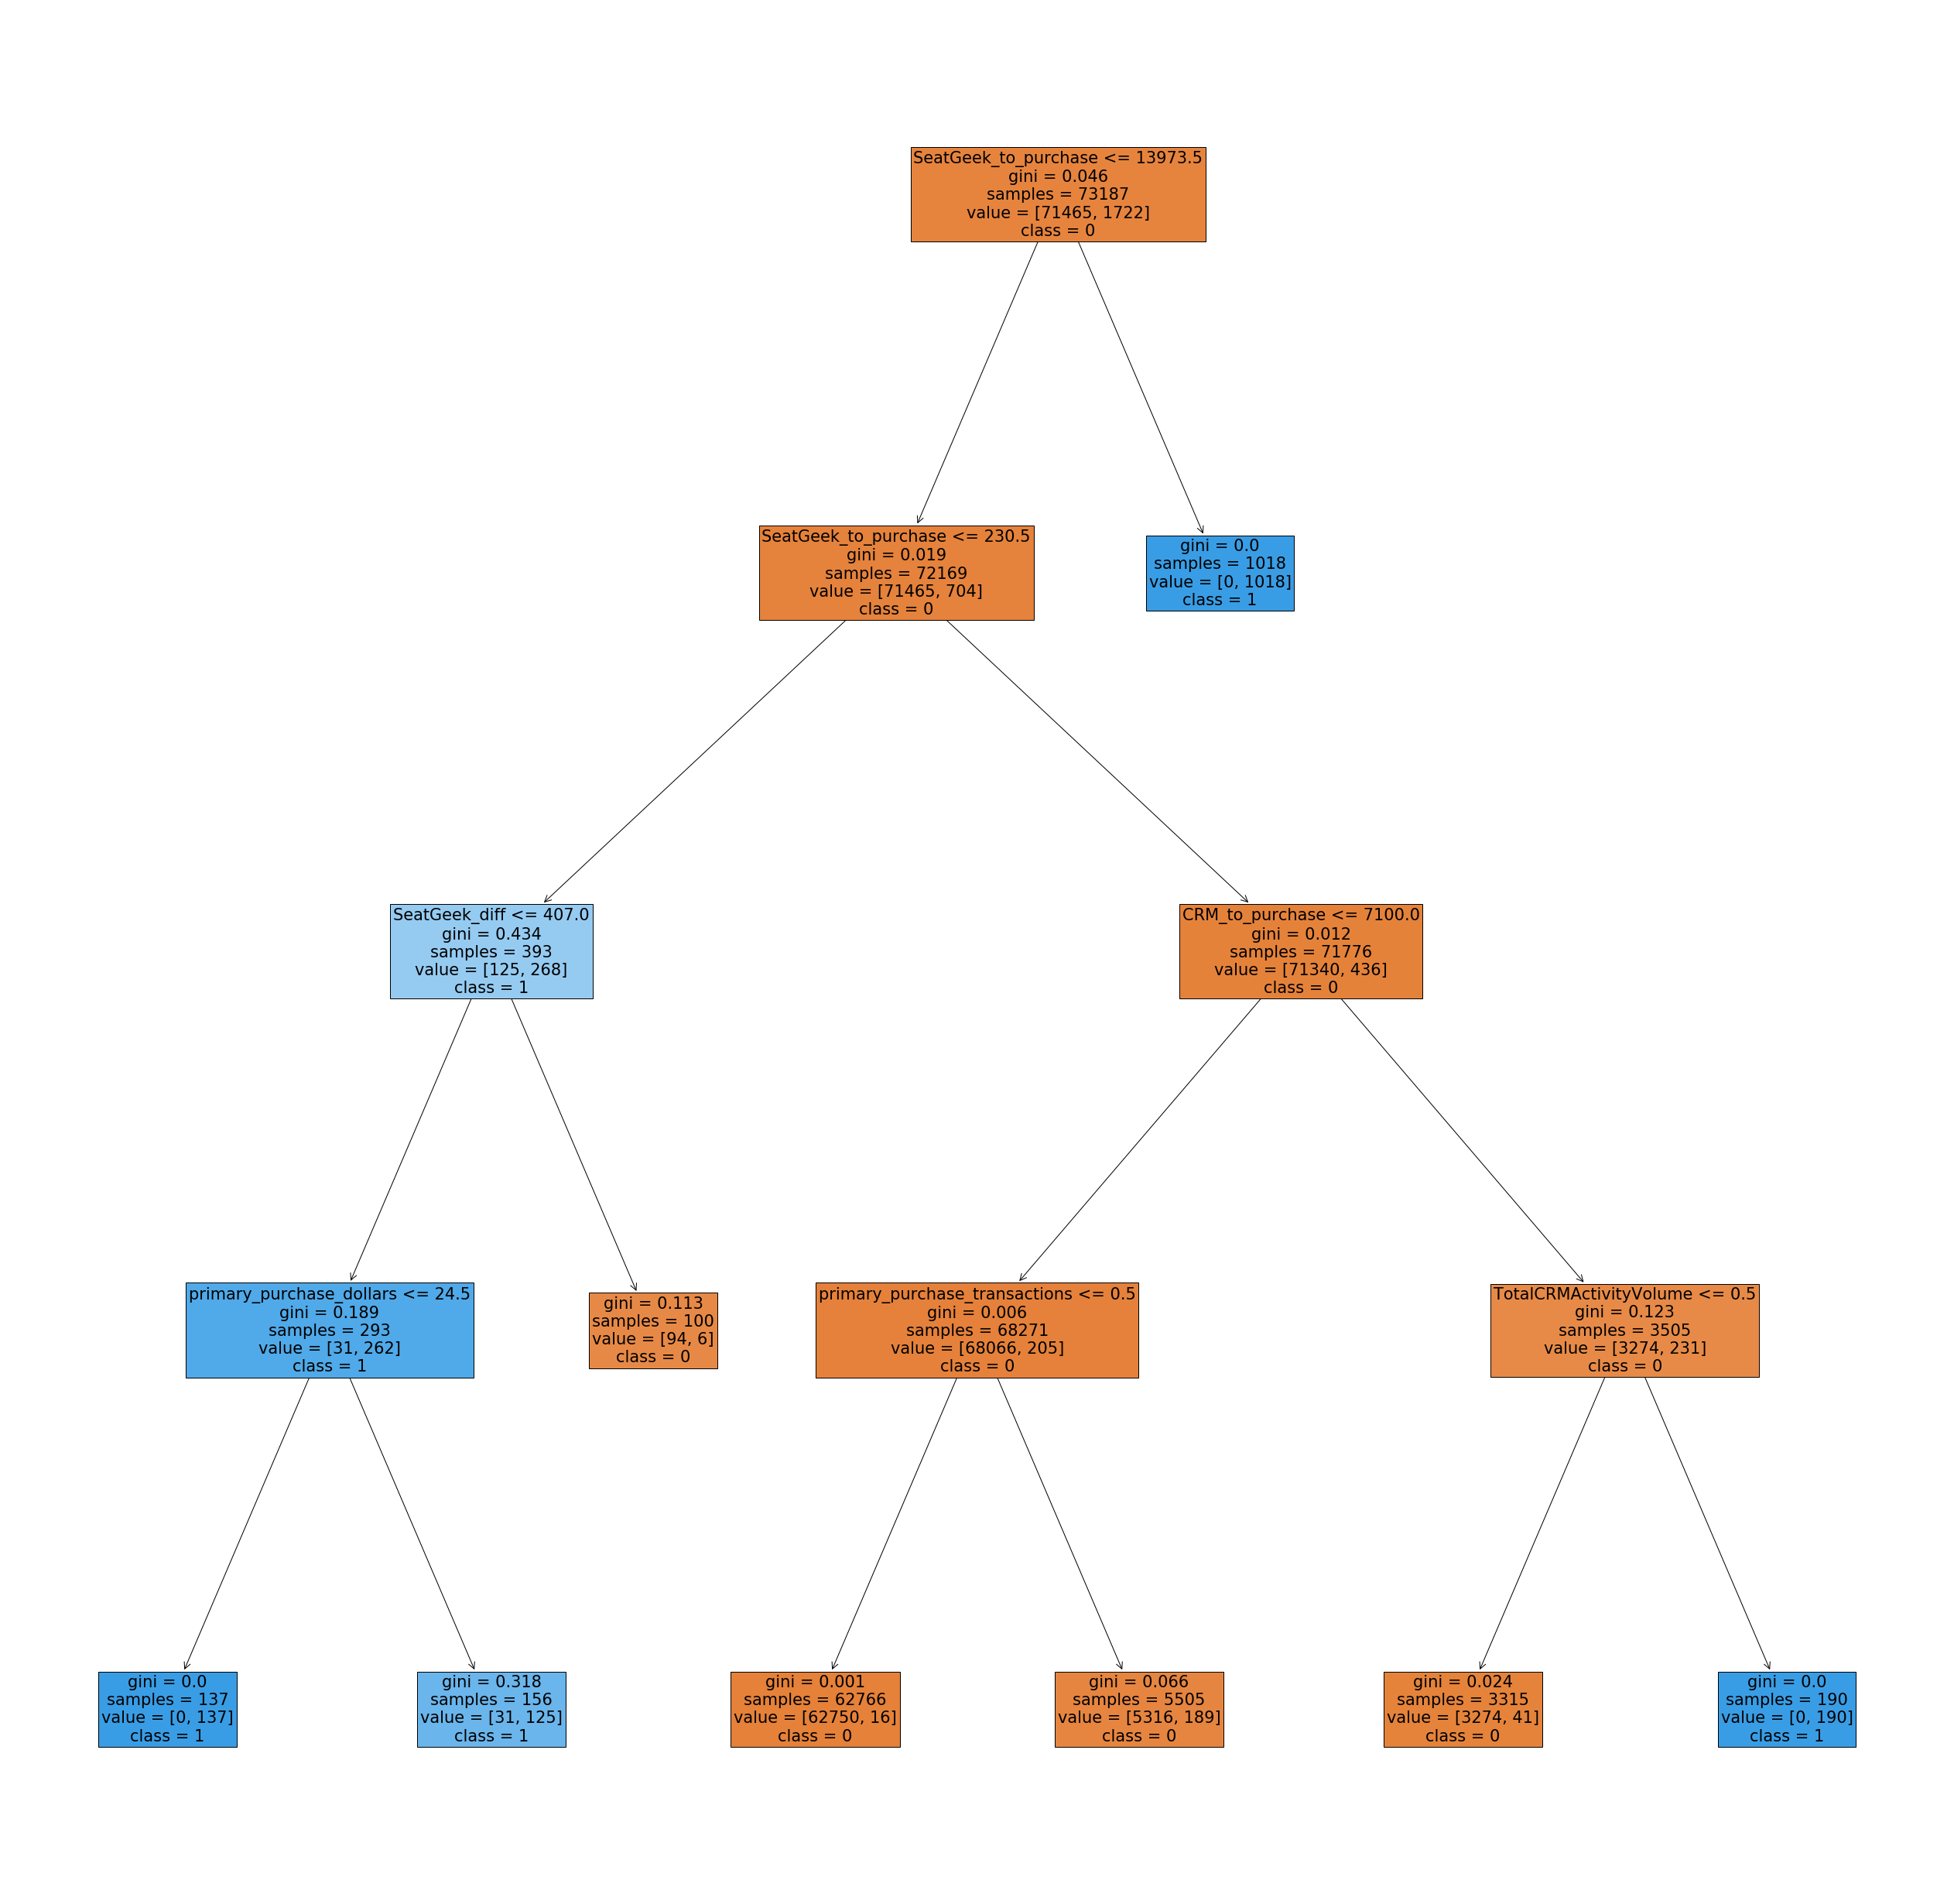

In [156]:
from sklearn import tree

fig = plt.figure(figsize=(45,45))
plt.rcParams.update({'font.size': 22})
_ = tree.plot_tree(clf, 
                   feature_names=X.columns,  
                   class_names=['0', '1'],
                   filled=True)



In [123]:
preds_proba

array([[0.99724558, 0.00275442],
       [0.99724558, 0.00275442],
       [0.99724558, 0.00275442],
       ...,
       [0.99724558, 0.00275442],
       [0.99724558, 0.00275442],
       [0.99724558, 0.00275442]])